# The best performing model so far on asl100

In [1]:
import torch
import test
from configs import Config
from torchvision.transforms import v2
from video_dataset import VideoDataset
import os
from torch.utils.data import DataLoader
from models.pytorch_r3d import Resnet3D18_basic

In [2]:
torch.manual_seed(42)
labels='./preprocessed/labels/asl100'
output='runs/asl100/r3d18_exp5'
model_dict='best.pth'
config_path = './configfiles/asl100.ini'
root='../data/WLASL2000'
classes_path = './wlasl_class_list.json'

In [3]:
configs = Config(config_path)
test.run_test_r3d18_1(configs,
                      root=root,
                      output=output,
                      labels=labels,
                      model_dict=model_dict,
                      save=True)

/home/luke/ExtraStorage/WLASL/lukes-code/test.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r3d18_dict = torch.load(os.path.join(output,'checkpoints', model_dict)) #

Using device: cuda


Testing: 100%|██████████| 258/258 [00:27<00:00,  9.26it/s]

top-k average per class acc: 0.6218333333333333, 0.8483333333333333, 0.8916666666666667


In [4]:
#setup transforms
base_mean = [0.43216, 0.394666, 0.37645]
base_std = [0.22803, 0.22145, 0.216989]

r3d18_final = v2.Compose([
  v2.Lambda(lambda x: x.float() / 255.0),
  # v2.Lambda(lambda x: vt.normalise(x, base_mean, base_std)),
  v2.Normalize(mean=base_mean, std=base_std),
  v2.Lambda(lambda x: x.permute(1,0,2,3)) 
])

test_transforms = v2.Compose([v2.CenterCrop(224),
                              r3d18_final])

#setup data
test_instances = os.path.join(labels, 'test_instances_fixed_frange_bboxes_len.json')
test_classes = os.path.join(labels, 'test_classes_fixed_frange_bboxes_len.json')

test_set = VideoDataset(root, test_instances, test_classes,
                        transforms=test_transforms, num_frames=32)
test_loader = DataLoader(test_set, batch_size=1,shuffle=False,
                          num_workers=0)
num_classes = len(set(test_set.classes))
# print(num_classes)

#setup model
r3d18 = Resnet3D18_basic(num_classes=num_classes, drop_p=configs.drop_p,)
r3d18_dict = torch.load(os.path.join(output,'checkpoints', model_dict)) #future warning, use weights_only=True (security stuff if you dont know the file)
# print(r3d18_dict)
r3d18.load_state_dict(r3d18_dict)
r3d18.cuda()
r3d18.eval()

accuracy, class_report = test.test_model(r3d18, test_loader)
print(f'Accuracy score: {accuracy}')

/tmp/ipykernel_2642282/3492383755.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r3d18_dict = torch.load(os.path.join(output,'checkpoints', model_dict)) #future warnin

Accuracy score: 0.6162790697674418


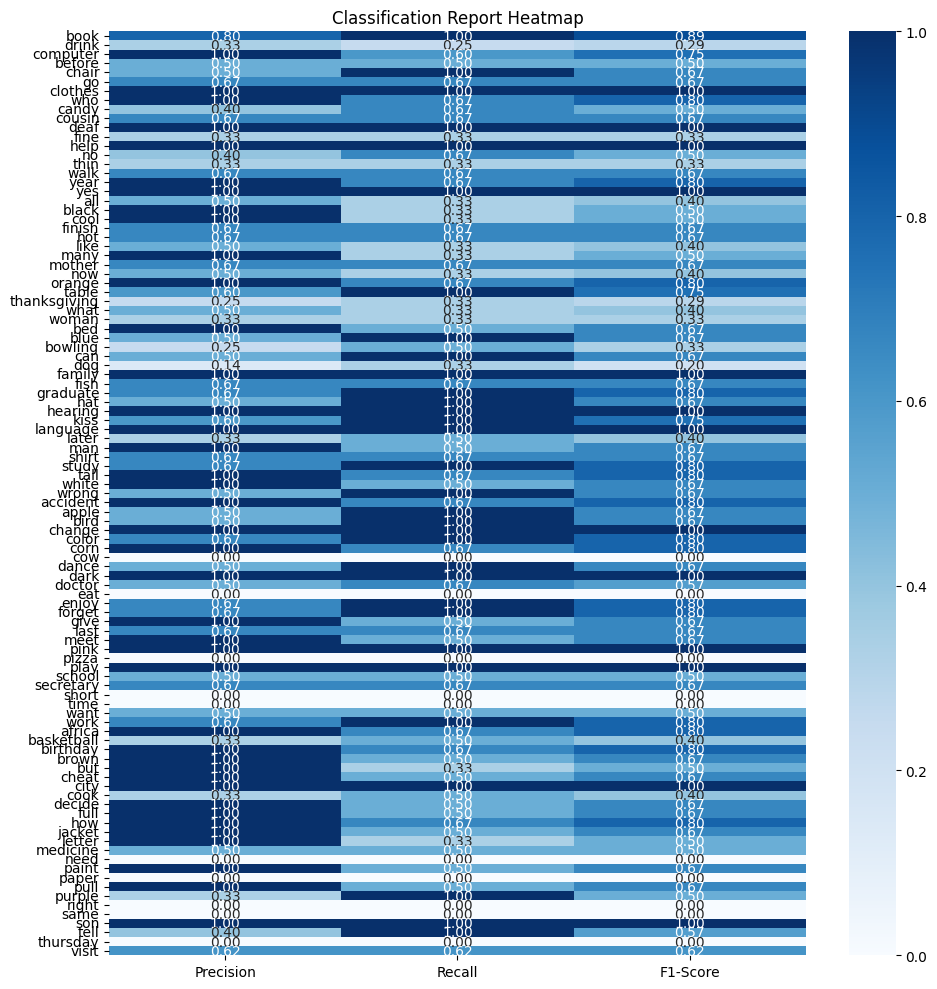

In [5]:
test.plot_heatmap(class_report, classes_path)

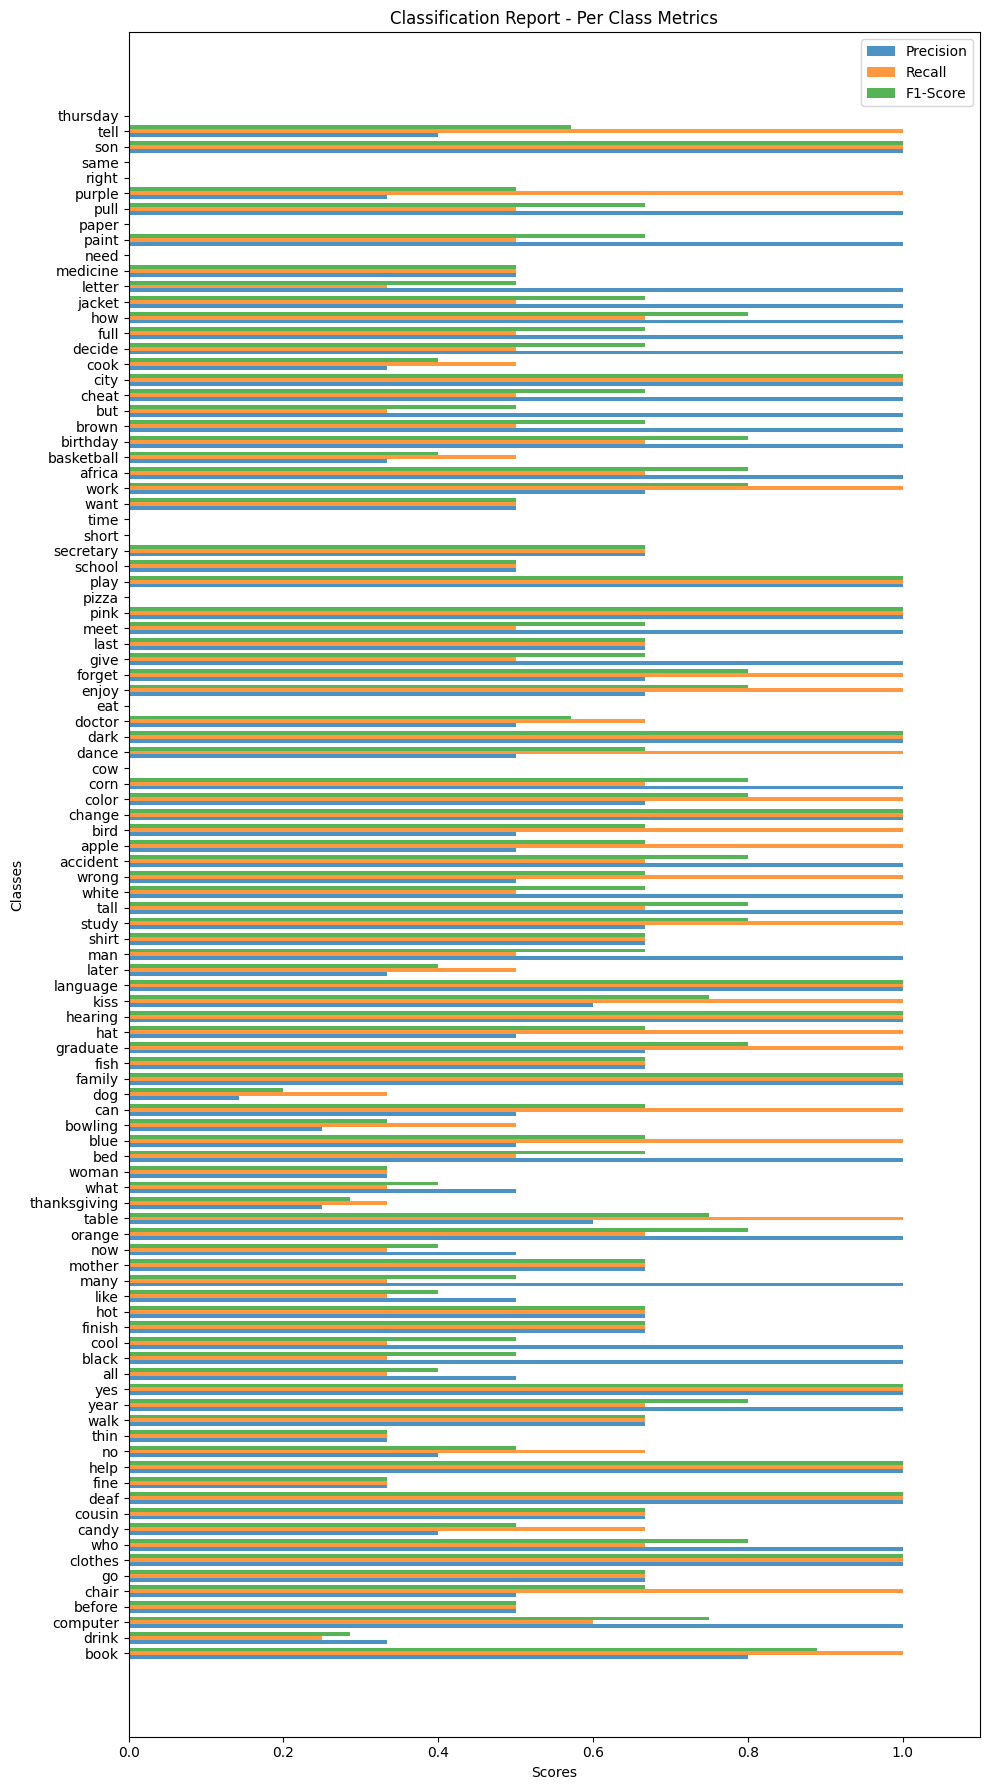

In [6]:
test.plot_bar_graph(class_report, classes_path)

## Whats weird is that the classes can almost be split into distinct difficulty groups

The model seems to have fully learned some signs, while completely failing to learn others. The rest have stagering degrees of recognition. 